In [1]:
# Adapted from Robert Guthrie https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
# And: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
import sklearn
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json
import zoib

np.random.seed(55)
torch.manual_seed(26)

In [2]:
def split_train_test_val(df):
    ind_year = np.where(np.array(df.index.names)=='year')[0][0]
    train_df = df.loc[df.index.get_level_values(ind_year)<=2010]
    val_df = df.loc[(df.index.get_level_values(ind_year)>2010) & (df.index.get_level_values(ind_year)<=2014)]
    test_df = df.loc[df.index.get_level_values(ind_year)>2014]
    return train_df, val_df, test_df

# Load data

In [3]:
# Set the number of playas from 1 to 8
num_playas = 1

In [4]:
# Read csv and set to appropriate number of playas
traj = pd.read_csv('./prepped_8.csv')
traj = traj.loc[traj['new_id'].isin(range(num_playas))]
# Set indices
traj.set_index(['year','month','id'], inplace=True)

# Drop embedding new_id
# traj.drop(columns=['new_id'], inplace=True)

# Here's a chance to drop everything else, if you'd like
traj = traj[['precip', 'temp','vpd','inundation']]
# traj['inundation'] = np.arange(traj.shape[0]).astype(float)
# traj['precip'] = 0

# # Simplified data
traj = traj[['precip','inundation']]
traj = traj.assign(precip=np.arange(traj.shape[0]).astype(float)*-1, inundation=np.arange(traj.shape[0]).astype(float))

# Prep data

In [5]:
# Params to set
hidden_dim = 32

num_layers=1
learning_rate = 0.02
num_epochs = 200
weight_decay = 0
lr_gamma = 1.0
lr_decay_step_size = 10 # Set this high if not needed
regularization_weight = 0
batch_size = 2

early_stopping=100000 # Set high if not needed

In [6]:
def split_by_id(x, y, seq_length):
    seq_starts = np.arange(0, x.shape[0], seq_length)
    x_arr = np.array([np.array(x[i:(i+seq_length)]) for i in seq_starts])
    y_arr = np.array([np.array(y[i:(i+seq_length)]) for i in seq_starts])
    return x_arr, y_arr

In [7]:
train, val, test = split_train_test_val(traj)
train_X, train_y = train.values[:, :-1], train.values[:, -1]
val_X, val_y = val.values[:, :-1], val.values[:, -1]
test_X, test_y = test.values[:, :-1], test.values[:, -1]

In [8]:
scaler = StandardScaler()
train, val, test = split_train_test_val(traj)
train_X, train_y = train.values[:, :-1], train.values[:, -1]
val_X, val_y = val.values[:, :-1], val.values[:, -1]
test_X, test_y = test.values[:, :-1], test.values[:, -1]
# Run scaler, but not on ID
train_X[:,:] = scaler.fit_transform(train_X[:,:])
val_X[:,:] = scaler.transform(val_X[:,:])
test_X[:,:] = scaler.transform(test_X[:,:])

# num_playas = int(train_X[:, -1].max())+1
lstm_input_size = traj.shape[1]-1

In [9]:
# Split into arrays by id
train_X_array, train_y = split_by_id(train_X, train_y, seq_length=int(train.shape[0]/num_playas))
val_X_array, val_y = split_by_id(val_X, val_y, seq_length=int(val.shape[0]/num_playas))
test_X_array, test_y = split_by_id(test_X, test_y, seq_length=int(test.shape[0]/num_playas))


In [10]:
train_val_ds = torch.utils.data.TensorDataset(torch.Tensor(train_X_array), torch.Tensor(train_y), torch.Tensor(val_X_array), torch.Tensor(val_y))
train_val_loader = torch.utils.data.DataLoader(train_val_ds, batch_size=batch_size, shuffle=True, drop_last=False)


In [11]:
# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim=1,
                    num_layers=1):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_playas = num_playas
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)

        # Define activations for output
        self.linear = nn.Linear(self.hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.exp = torch.exp
    

    def init_hidden(self, batch_size):
        self.h = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        self.c = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        return

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of input: [batch_size, timesteps, input_dims]
        # shape of lstm_out: [batch_size, timesteps, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        # Shape of y_pred: [batch_size, timesteps, 1]
        # Run ids through embedding layer        
        # Concat and run through LSTM
        
        assert self.h.shape == torch.Size([self.num_layers, input.size(0), self.hidden_dim])
        assert self.c.shape == torch.Size([self.num_layers, input.size(0), self.hidden_dim])

        
        lstm_out, (self.h, self.c) = self.lstm(input, (self.h, self.c))
        
        # Assert that shapes are still as expected
        assert self.h.shape == torch.Size([self.num_layers, input.size(0), self.hidden_dim])
        assert self.c.shape == torch.Size([self.num_layers, input.size(0), self.hidden_dim])
        assert lstm_out.shape == torch.Size([input.size(0), input.size(1), self.hidden_dim]) # batch, seq_len, hidden

        
        # Run activation and get outputs
        lin_act = self.linear(lstm_out)
        exp_act = self.exp(lin_act)
        # Expect [batch_size, seq_len, 1]
        assert lin_act.shape == torch.Size([input.size(0), input.size(1), 1])
        assert lin_act.shape == exp_act.shape

        return exp_act


model = LSTM(input_dim = lstm_input_size,
             hidden_dim=hidden_dim,
             output_dim=1,
             num_layers=num_layers)

In [12]:
l1_loss = nn.L1Loss()
    
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=lr_decay_step_size, gamma=lr_gamma)
#####################---------------------------------------------------------------------------
# Train model
#####################

loss_history = []
val_loss_history = []

best_loss = 1000
for t in range(num_epochs):
    epoch_loss = 0
    val_epoch_loss = 0
    total_items = 0
    val_total_items = 0
    # List to store all predictions
    all_train_pred = []
    all_val_pred = []
    for x_batch, y_batch, val_x_batch, val_y_batch in train_val_loader: 
        
        # Clear stored gradient
        optimiser.zero_grad()
        
        # Init hidden state
        model.init_hidden(batch_size=x_batch.size(0))
        
        # Training: Predict and calc loss
        train_pred = model(x_batch)
        loss = l1_loss(train_pred.view(len(train_pred), -1), y_batch)
        all_train_pred.append(train_pred)
        
        # Tracking mean loss across batches
        epoch_loss += train_pred.shape[0]*loss.item()
        total_items += train_pred.shape[0]
        
        
        # Validation: predict and calc loss
        val_pred = model(val_x_batch)
        val_loss = l1_loss(val_pred.view(len(val_pred), -1), val_y_batch)

        all_val_pred.append(val_pred)

        # Tracking mean loss across batches
        val_epoch_loss += val_pred.shape[0]*val_loss.item()
        val_total_items += val_pred.shape[0]


        # Backward pass
        loss.backward()
        
        # Update parameters
        optimiser.step()

    # LR decay
    scheduler.step()
    
    epoch_loss = epoch_loss/total_items
    val_epoch_loss = val_epoch_loss/val_total_items
    loss_history.append(epoch_loss)
    val_loss_history.append(val_epoch_loss)
    if t%10==0:
        print("Epoch ", t, "Train Loss: ", epoch_loss, "Val Loss:", val_epoch_loss, "LR: ", optimiser.param_groups[0]["lr"])
        
    if np.isnan(epoch_loss):
        break
        
    # Early stopping
    if epoch_loss < best_loss:
        i = 0
        # Save best loss, predictoins, and hidden state
        best_loss = epoch_loss
        best_train_pred = torch.cat(all_train_pred.copy(), dim=0)
        best_val_pred = torch.cat(all_val_pred.copy(), dim=0)    
    if (i > early_stopping):
        break

Epoch  0 Train Loss:  159.47930908203125 Val Loss: 344.4944152832031 LR:  0.02
Epoch  10 Train Loss:  85.12909698486328 Val Loss: 117.2270278930664 LR:  0.02
Epoch  20 Train Loss:  67.0992431640625 Val Loss: 158.50262451171875 LR:  0.02
Epoch  30 Train Loss:  48.334129333496094 Val Loss: 32.988529205322266 LR:  0.02
Epoch  40 Train Loss:  8.385600090026855 Val Loss: 18.312597274780273 LR:  0.02
Epoch  50 Train Loss:  8.089193344116211 Val Loss: 3.907041549682617 LR:  0.02
Epoch  60 Train Loss:  5.22587251663208 Val Loss: 16.582603454589844 LR:  0.02
Epoch  70 Train Loss:  18.810529708862305 Val Loss: 39.15554428100586 LR:  0.02
Epoch  80 Train Loss:  33.52695846557617 Val Loss: 53.29928970336914 LR:  0.02
Epoch  90 Train Loss:  17.887550354003906 Val Loss: 51.79435348510742 LR:  0.02
Epoch  100 Train Loss:  5.4646687507629395 Val Loss: 27.291635513305664 LR:  0.02
Epoch  110 Train Loss:  21.29233169555664 Val Loss: 22.970945358276367 LR:  0.02
Epoch  120 Train Loss:  30.042980194091797


# View results

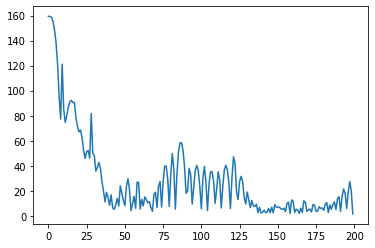

In [13]:
plt.plot(loss_history)

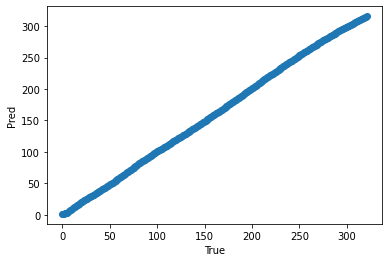

In [14]:
plt.scatter(train_y.flatten(), best_train_pred.detach().numpy().flatten())
plt.xlabel('True')
plt.ylabel('Pred')
plt.show()

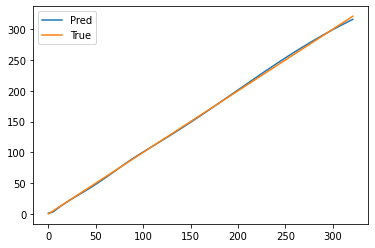

In [15]:
pd.DataFrame({'Pred':best_train_pred.detach().numpy().flatten(), 'True':train_y.flatten()}).plot()

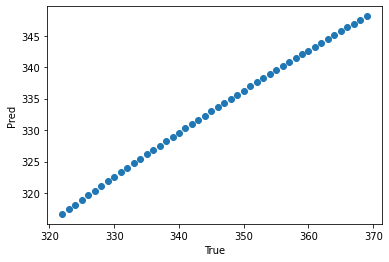

In [16]:
plt.scatter(val_y.flatten(), best_val_pred.detach().numpy().flatten())
plt.xlabel('True')
plt.ylabel('Pred')
plt.show()

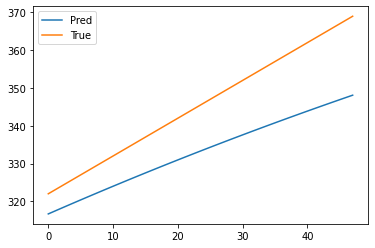

In [17]:
pd.DataFrame({'Pred':best_val_pred.detach().numpy().flatten(), 'True':val_y.flatten()}).plot()